In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.layers import Flatten, Dense, Activation
import matplotlib.pyplot as plt
from scipy.integrate import simps
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import visualkeras
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from PIL import Image
import pickle


## extracting_images , Data preprocessing and augmentation

In [10]:
dataset_dir=r"/home/gourav/Desktop/vss/DEEP LEARNING/dataset_fire/train"
classes=['fire','nofire']
input_shape = (224, 224, 3)
num_classes = 1
batch_size = 32
epochs = 50


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb', 
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    subset='validation'
)

Found 5398 images belonging to 2 classes.
Found 1348 images belonging to 2 classes.


## visualization of images

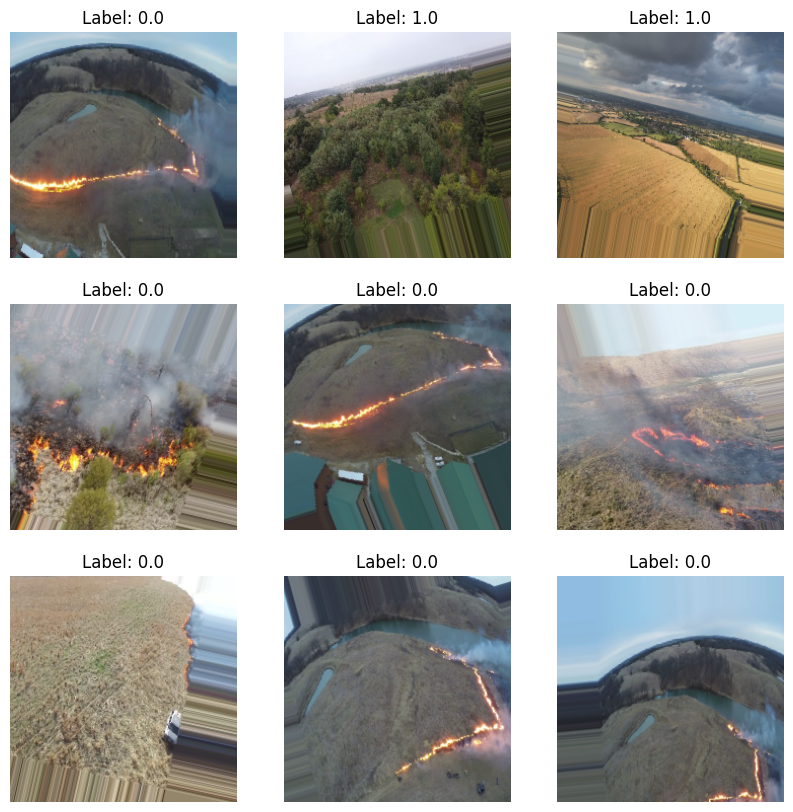

In [11]:
batch = next(train_generator)
images = batch[0] 
labels = batch[1] 

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap='gray') 
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.show()


## model

In [12]:

base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

for layer in base_model.layers[:-10]:
     layer.trainable = False

base_input = base_model.input
base_output = base_model.layers[-1].output  
# base output is output tensor which means what is output shape that means what input shape is getting in 2d layer ......... output of base output
x = GlobalAveragePooling2D()(base_output)  
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
final_output = Dense(num_classes)(x) 

final_model = Model(inputs=base_input, outputs=final_output)

## compiling model- Model: "mobilenet_1.00_224"

In [13]:
final_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()])

final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [14]:
import tensorflow as tf

def check_cuda_tensorflow():
    # Check TensorFlow version
    print("TensorFlow version:", tf.__version__)
    
    # Check if TensorFlow can access GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        
        print("TensorFlow is using the following GPU(s):")
        for gpu in gpus:
            print(f" - {gpu}")
        
        # Optional: Print CUDA device properties
        for gpu in gpus:
            details = tf.config.experimental.get_device_details(gpu)
            print(details)
    else:
        print("No GPU available. TensorFlow is using the CPU.")

# Run the check
check_cuda_tensorflow()


TensorFlow version: 2.14.0
TensorFlow is using the following GPU(s):
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
{'compute_capability': (8, 6), 'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU'}


2024-11-04 23:32:06.583042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [15]:
steps_per_epoch = 5398// batch_size
validation_steps =  1348// batch_size

## Training

In [16]:



history = final_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    )

Epoch 1/50
168/168 [==============================] - 71s 409ms/step - loss: 6.0603 - binary_accuracy: 0.9506 - precision_1: 0.9581 - recall_1: 0.9411 - auc_1: 0.9672 - val_loss: 5.2244 - val_binary_accuracy: 0.9077 - val_precision_1: 0.8921 - val_recall_1: 0.9245 - val_auc_1: 0.9227
Epoch 2/50
168/168 [==============================] - 71s 425ms/step - loss: 4.2321 - binary_accuracy: 0.9922 - precision_1: 0.9939 - recall_1: 0.9902 - auc_1: 0.9956 - val_loss: 3.5782 - val_binary_accuracy: 0.9412 - val_precision_1: 0.9536 - val_recall_1: 0.9263 - val_auc_1: 0.9541
Epoch 3/50
168/168 [==============================] - 82s 486ms/step - loss: 2.8769 - binary_accuracy: 0.9974 - precision_1: 0.9985 - recall_1: 0.9962 - auc_1: 0.9985 - val_loss: 2.5081 - val_binary_accuracy: 0.9382 - val_precision_1: 0.9866 - val_recall_1: 0.8869 - val_auc_1: 0.9423
Epoch 4/50
168/168 [==============================] - 76s 452ms/step - loss: 1.9270 - binary_accuracy: 0.9981 - precision_1: 0.9977 - recall_1: 0

In [17]:
final_model.save('model_wildfire.h5')

/home/gourav/anaconda3/envs/gpu2/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Testing 

In [ ]:

    
model = keras.models.load_model('model_wildfire.h5')
compiled_metrics = model.metrics

test_data_generator = ImageDataGenerator(rescale=1.0/255.0)  

test_generator = test_data_generator.flow_from_directory(
    '/home/gourav/Desktop/vss/DEEP LEARNING/dataset_fire/test',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False 
)

result = model.evaluate(test_generator)

print("Test Loss:", result[0])
print("Test Accuracy:", result[1])
print("Test Accuracy:", result[1]*100)

Found 900 images belonging to 2 classes.
29/29 [==============================] - 5s 174ms/step - loss: 0.0100 - binary_accuracy: 0.9989 - precision_1: 0.9950 - recall_1: 1.0000 - auc_1: 1.0000
Test Loss: 0.010035192593932152
Test Accuracy: 0.9988889098167419
Test Accuracy: 99.8888909816742


 ## Plotting training and validation loss over epochs

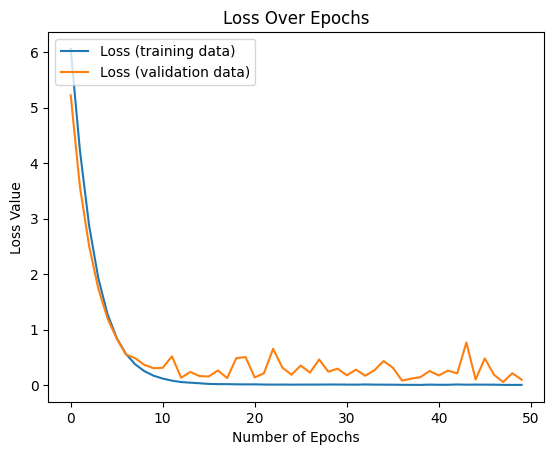

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss Over Epochs')
plt.ylabel('Loss Value')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('Training-Validation_loss_v1_softplus_100_layer_4_original_data.png')
plt.show()


## accuracy

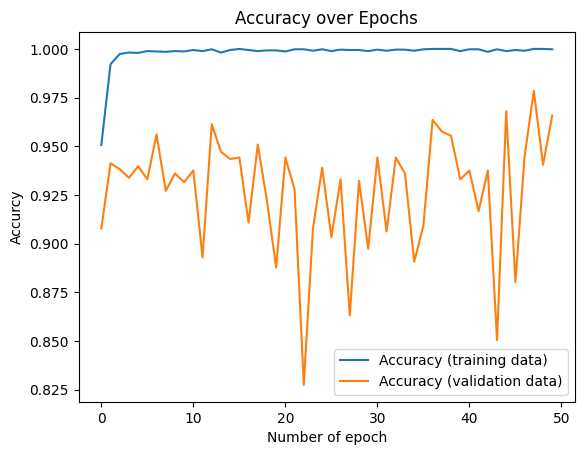

In [20]:
plt.plot(history.history['binary_accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_binary_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy over Epochs')
plt.ylabel('Accurcy')
plt.xlabel('Number of epoch')
plt.legend(loc="lower right")
plt.show()


## Confusion Matrix

29/29 [==============================] - 4s 143ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       700
           1       1.00      1.00      1.00       200

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900


Confusion Matrix:
[[699   1]
 [  0 200]]


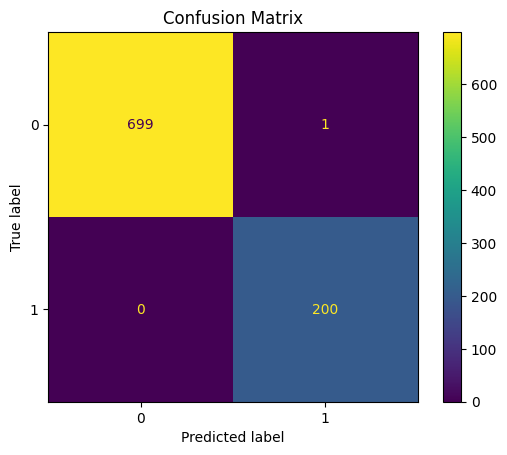

In [21]:
# Predictions
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype('int32').flatten()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plotting Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion Matrix')
plt.show()



In [ ]:
# Detailed Accuracy Metrics
print("\nDetailed Accuracy Metrics:")
report = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()), output_dict=True)
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"Class '{label}' - Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-Score: {metrics['f1-score']:.2f}")

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define paths and parameters
model_path = r'"C:\Users\raphe\Webdev\sideQuest\RaghavsModel\model_wildfire.h5"'#path of model trained
image_path = r"Screenshot 2025-11-18 135110.png"  # Replace with your image path
input_shape = (224, 224)  # Model input size
# Load the trained model
model = keras.models.load_model(model_path)
# Preprocessing function for a single image
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image to the model's input size
    image_resized = cv2.resize(image_rgb, target_size)

    # Normalize image to [0, 1] range
    image_normalized = image_resized / 255.0

    # Expand dimensions to match input shape (1, height, width, channels)
    image_preprocessed = np.expand_dims(image_normalized, axis=0)
    
    return image_preprocessed, image_rgb

# Function to predict and display the result on the image
def predict_and_display(image_path):

    # Preprocess the image
    input_image, original_image = preprocess_image(image_path, input_shape)

    # Perform prediction
    prediction = model.predict(input_image)
    confidence = prediction[0][0]
    print(prediction)
    # Determine class label and prediction text
    predicted_class = "Fire Detected" if confidence <= 0.5 else "No Fire"
    color = (0, 255, 0) if predicted_class == "No Fire" else (0, 0, 255)
    confidence_text = f"{predicted_class}"

    # Annotate the original image
    annotated_image = cv2.putText(
        original_image.copy(),
        confidence_text,
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        color,
        2,
        cv2.LINE_AA
    )

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.show()

# Run inference and display the image
predict_and_display(image_path)


NameError: name 'image_path' is not defined